# DCGAN per la generazione di loghi

Questo notebook implementa una Deep Convolutional Generative Adversarial Network (GAN) progettata per generare variazioni di loghi basate sulle immagini presenti nel dataset LLD (Large Logo Dataset: https://data.vision.ee.ethz.ch/sagea/lld/).

Il modello è composto da:
- Un generatore: che trasforma un vettore casuale (rumore) in un'immagine (logo).
- Un discriminatore: che valuta se un'immagine è "reale" (dal dataset) oppure "finta" (generata).

L'obiettivo è allenare entrambi i modelli in maniera competitiva, in modo che il generatore impari a produrre immagini realistiche e il discriminatore a distinguerle (https://keras.io/examples/generative/dcgan_overriding_train_step/).

Al termine confrontiamo la qualità delle immagini generate rispetto a quelle reali utilizzto il Frechet Inception Distance (FID: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/).


#Importazioni

##Librerie

Importiamo le librerie necessarie e configuriamo l’esecuzione eager.

In [ ]:
# Importazioni delle librerie principali
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, ops

# Callback per salvare i pesi del modello durante l'allenamento
from tensorflow.keras.callbacks import ModelCheckpoint

# Importazione del modello InceptionV3 e la funzione per il preprocessamento delle immagini.
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Importazione di librerie per la visualizzazione grafica
import matplotlib.pyplot as plt

# Importazione di librerie per la manipolazione dei dati e operazioni matematiche
import numpy as np
from numpy import cov, trace, iscomplexobj, asarray
from scipy.linalg import sqrtm
from skimage.transform import resize

# Importazione di librerie per la gestione di file e directory
import os
from pathlib import Path
from zipfile import ZipFile

# Forzatura dell'esecuzione in modalità "eager" per evitare il sovraccarico della RAM
tf.config.run_functions_eagerly(True)

In [ ]:
# Monta Google Drive per accedere ai file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Preparazione del dataset

Estraiamo il file ZIP contenente i loghi e creiamo una directory locale per i dati.



In [ ]:
# Specifica del percorso del dataset ZIP presente su Google Drive
dataset_path = '/content/drive/MyDrive/LLD-icon_PNG.zip'

# Creazione della directory locale "LLD_gan" per estrarre il dataset se non esiste già
output_dir = "LLD_gan"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Estrazione del file ZIP nella directory di output
with ZipFile(dataset_path, "r") as zipobj:
    zipobj.extractall(output_dir)

##Caricamento e preprocessing del dataset

Carichiamo le immagini dal dataset, le ridimensioniamo a 32x32 pixel e le normalizziamo nel range [0,1].

In [ ]:
# Carica il dataset dalle immagini contenute nella directory "LLD_gan"
dataset = keras.utils.image_dataset_from_directory(
    "LLD_gan", # Directory contenente le immagini
    label_mode=None, # Non usiamo etichette perché ci interessa solo la generazione.
    image_size=(32, 32), # Ridimensiona le immagini a 32x32 pixel
    batch_size=512 # Numero di immagini per batch
)

# Normalizza le immagini, portando i pixel nel range [0, 1]
dataset = dataset.map(lambda x: x / 255.0)

Found 485377 files.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


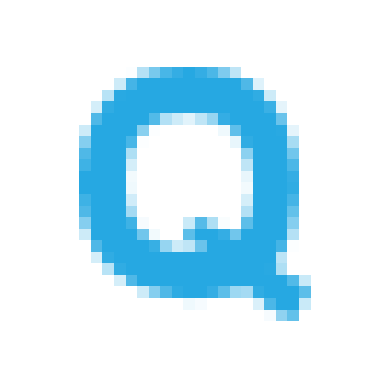

In [ ]:
# Visualizza la prima immagine del dataset per verifica
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

#Architettura della rete

##Generatore

Il generatore trasforma un vettore casuale (dimensione 128) in un'immagine 32x32 a colori.
1. Un layer Dense trasforma il vettore in un tensore 3D (8,8,128).
2. I layers Conv2DTranspose aumentano progressivamente la dimensione.
3. Ogni layer utilizza LeakyReLU per la non linearità.
4. L'output è un'immagine RGB con attivazione sigmoide per normalizzare i valori. Questo perché aiuta la stabilità numerica e facilita la convergenza durante l'addestramento.




In [ ]:
# Dimensione dello spazio latente
latent_dim = 128

# Costruzione del generatore tramite modello sequenziale
generator = keras.Sequential(
    [
        # Definisce l'input con la dimensione del rumore
        keras.Input(shape=(latent_dim,)),
        # Trasforma il vettore in un tensore 3D (8x8x128)
        layers.Dense(8 * 8 * 128),
        # Riorganizza il vettore in una matrice 8x8 con 128 canali
        layers.Reshape((8, 8, 128)),
        # Primo layer di Conv2DTranspose per aumentare la dimensione
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # Funzione di attivazione LeakyReLU per introdurre non linearità
        layers.LeakyReLU(negative_slope=0.2),
        # Secondo layer di Conv2DTranspose
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # Funzione di attivazione LeakyReLU per introdurre non linearità
        layers.LeakyReLU(negative_slope=0.2),
        # Layer finale per ottenere un'immagine RGB, kernel_size=5 e attivazione sigmoide
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

# Visualizza il sommario del modello generatore
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 3)           │          19,203 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,862,787 (7.11 MB)

 Trainable params: 1,862,787 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

##Discriminatore

Il discriminatore valuta se un'immagine (32x32x3) è reale o generata.
1. Viene usata una serie di layer Conv2D per ridurre le dimensioni spaziali.
2. Ogni layer utilizza LeakyReLU per la non linearità.
3. Dopo aver appiattito il tensore, si usa un layer Dropout per evitare overfitting.
4. L'output finale è un singolo neurone con attivazione sigmoide, che produce un valore in [0, 1].


In [ ]:
# Costruzione del discriminatore tramite modello sequenziale
discriminator = keras.Sequential(
    [
        # Input: immagine 32x32 con 3 canali (RGB)
        keras.Input(shape=(32, 32, 3)),
        # Primo layer di convoluzione: riduce la dimensione spaziale
        layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),
        # Funzione di attivazione LeakyReLU per introdurre non linearità
        layers.LeakyReLU(negative_slope=0.2),
        # Secondo layer di convoluzione
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        # Funzione di attivazione LeakyReLU per introdurre non linearità
        layers.LeakyReLU(negative_slope=0.2),
        # Terzo layer di convoluzione
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        # Funzione di attivazione LeakyReLU per introdurre non linearità
        layers.LeakyReLU(negative_slope=0.2),
        # Appiattisce il tensore in un vettore 1D
        layers.Flatten(),
        # Applica Dropout per evitare l'overfitting (disattivazione casuale del 30% dei neuroni)
        layers.Dropout(0.3),
        # Singolo neurone con attivazione sigmoide per classificare reale/falso
        layers.Dense(1, activation="sigmoid"),

    ],
    name="discriminator",
)

# Visualizza il sommario del modello discriminatore
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 64)            │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,025 (394.63 KB)

 Trainable params: 101,025 (394.63 KB)

 Non-trainable params: 0 (0.00 B)

#Modello GAN

##Creazione della classe GAN

Definiamo la classe personalizzata per la GAN, implementando il ciclo di training alternato per discriminatore e generatore.

In [ ]:
# Crea una classe che eredita da keras.Model per definire il comportamento della GAN

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        """
        Inizializza il modello GAN.
        Args:
            discriminator: il modello discriminatore
            generator: il modello generatore
            latent_dim: dimensione dello spazio latente
        """
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        # Generatore di seed per garantire la ripetibilità nella generazione delle immagini
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        """
        Configura la GAN con ottimizzatori e funzione di loss.
        Args:
            d_optimizer: ottimizzatore per il discriminatore.
            g_optimizer: ottimizzatore per il generatore.
            loss_fn: funzione di loss.
        """
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

        # Metriche per monitorare le loss dei due modelli
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        """
        Restituisce le metriche per il monitoraggio durante l'allenamento.
        """
        return [self.d_loss_metric, self.g_loss_metric]


    def train_step(self, real_images):
        """
        Definisce un singolo passo di allenamento.
        Args:
            real_images: batch di immagini reali.
        Returns:
            Un dizionario con le perdite attuali per il discriminatore e il generatore.
        """
        # Dimensione del batch
        batch_size = tf.shape(real_images)[0]

        # Addestramento del Discriminatore

        # Genera vettori casuali per creare immagini false.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Crea immagini false tramite il generatore
        generated_images = self.generator(random_latent_vectors)
        # Combina immagini reali e quelle generate in un unico batch
        combined_images = tf.concat([real_images, generated_images], axis=0)
        # Crea le etichette: 1 per immagini reali, 0 per immagini generate
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Aggiunge un po' di rumore alle etichette per stabilizzare l'allenamento
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Calcola la loss del discriminatore con GradientTape
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        # Calcola i gradienti rispetto ai pesi del discriminatore
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Applica i gradienti per aggiornare i pesi
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        # Aggiorna la metrica della loss del discriminatore
        self.d_loss_metric.update_state(d_loss)

        # Addestramento del Generatore

        # Genera nuovi vettori casuali
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Per il generatore, le etichette "vere" sono usate per ingannare il discriminatore
        misleading_labels = tf.ones((batch_size, 1))

        # Calcola la loss del generatore con GradientTape
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        # Calcola i gradienti rispetto ai pesi del generatore
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        # Applica i gradienti per aggiornare i pesi del generatore
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # Aggiorna la metrica della loss del generatore
        self.g_loss_metric.update_state(g_loss)

        # Restituisce le metriche di loss per il monitoraggio ad ogni epoca
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

##Salvataggio delle immagini generate

Implementiamo una classe callback per salvare le immagini generate ad ogni epoca e copiarle su Google Drive.

In [ ]:
# Definisce una classe Callback per salvare le immagini ad ogni epoca
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=128, output_dir="generated_images"):
        """
        Inizializza il monitor per salvare le immagini generate.
        Args:
            num_img: numero di immagini da generare per ogni epoca.
            latent_dim: dimensione dello spazio latente.
            output_dir: directory in cui salvare le immagini.
        """
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.output_dir = output_dir

        # Se la directory non esiste, creala
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def on_epoch_end(self, epoch, logs=None):
        """
        Al termine di ogni epoca:
          Genera alcune immagini.
          Salva le immagini in una sottocartella dedicata all'epoca corrente.
          Copia le immagini salvate su Google Drive per backup.
        """
        # Costruisce il percorso per la sottocartella di questa epoca
        epoch_dir = os.path.join(self.output_dir, f"epoca_{epoch + 1}")
        if not os.path.exists(epoch_dir):
            os.makedirs(epoch_dir)

        # Genera dei vettori casuali per creare immagini
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # Crea le immagini tramite il generatore del modello GAN
        generated_images = self.model.generator(random_latent_vectors)
        # Porta i valori dei pixel a [0,255]
        generated_images *= 255
        generated_images = generated_images.numpy().astype("uint8")

        # Salva ogni immagine all'interno della cartella dell'epoca corrente
        for i in range(self.num_img):
            img_path = os.path.join(epoch_dir, f"immagine_{i + 1}.png")
            plt.imsave(img_path, generated_images[i])

        # Copia le immagini generate su Google Drive per backup
        drive_output_dir = f"/content/drive/MyDrive/{self.output_dir}"
        if not os.path.exists(drive_output_dir):
            os.makedirs(drive_output_dir)

        drive_epoch_dir = os.path.join(drive_output_dir, f"epoca_{epoch + 1}")
        if not os.path.exists(drive_epoch_dir):
            os.makedirs(drive_epoch_dir)

        for i in range(self.num_img):
            source_path = os.path.join(epoch_dir, f"immagine_{i + 1}.png")
            target_path = os.path.join(drive_epoch_dir, f"immagine_{i + 1}.png")
            tf.io.gfile.copy(source_path, target_path, overwrite=True)

#Fase di Training

##Configurazione per il salvataggio dei pesi

Configuriamo il salvataggio dei pesi del modello ad ogni epoca e il caricamento dei pesi salvati (se presenti).



In [ ]:
# Directory su Google Drive dove salvare i pesi della GAN
weights_dir = '/content/drive/MyDrive/gan_weights'
os.makedirs(weights_dir, exist_ok=True)

# Definisce il percorso per salvare i pesi ad ogni epoca
latest_weights_path = os.path.join(weights_dir, 'gan_weights_epoch_{epoch:03d}.weights.h5')

# Callback per salvare i pesi alla fine di ogni epoca
checkpoint_callback = ModelCheckpoint(
    filepath=latest_weights_path, # Salva i pesi con nome che include l'epoca
    save_best_only=False, # Salva ad ogni epoca, non solo i migliori
    save_weights_only=True, # Salva solo i pesi, non l'intera architettura
    save_freq='epoch' # Salva ad ogni epoca
)

# Cerca eventuali file di pesi nella directory
weights_files = [f for f in os.listdir(weights_dir) if f.endswith('.h5')]
if weights_files:
    # Se esistono, sceglie quello con l'epoca più alta (l'ultimo salvato)
    latest_weights_file = max(weights_files, key=lambda f: int(f.split('_')[-1].split('.')[0]))
    latest_weights_path = os.path.join(weights_dir, latest_weights_file)
    print(f"Caricamento dei pesi salvati da {latest_weights_path}...")

    # Crea il modello GAN e carica i pesi salvati
    gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy()
    )
    # Costruisce il modello
    gan.build(input_shape=(None, latent_dim))
    # Carica i pesi salvati
    gan.load_weights(latest_weights_path)

    # Recupera il numero dell'epoca corrente dai pesi
    latest_epoch = int(latest_weights_file.split('_')[-1].split('.')[0])
else:
    print("Nessun peso trovato. Il modello inizierà l'allenamento da zero.")
    latest_epoch = 0 # Se non trova pesi, parte dall'epoca 0
    # Crea il modello GAN
    gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy()
    )
    # Costruisce il modello
    gan.build(input_shape=(None, latent_dim))

Caricamento dei pesi salvati da /content/drive/MyDrive/gan_weights/gan_weights_epoch_060.weights.h5...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Addestramento della GAN

Alleniamo il modello GAN sul dataset, utilizzando i callback per monitorare e salvare i progressi.

In [ ]:
# Allena la GAN sul dataset per 60 epoche
gan.fit(
    dataset,
    epochs=60, # Numero totale di epoche
    initial_epoch=latest_epoch, # Riprende dall'epoca salvata (oppure da 0)
    callbacks=[
        GANMonitor(num_img=10, latent_dim=latent_dim), # Callback per salvare immagini generate
        checkpoint_callback # Callback per salvare i pesi
    ],
)

## Salvataggio del modello e del generatore

In [ ]:
# Salva l'intero modello GAN (inclusa architettura e pesi)
gan.save("/content/drive/MyDrive/LLD_gan_model.h5")

# Salva separatamente il modello del generatore
generator.save("/content/drive/MyDrive/LLD_generator_model.h5")

##Visualizzazione delle immagini generate

Generiamo e visualizziamo una griglia di immagini create dal generatore.

In [ ]:
# Funzione per visualizzare 100 immagini casuali generate
def visualize_images(num_img=100, latent_dim=128, generator=generator):
    """
    Genera e visualizza num_img immagini create dal generatore in una griglia 10x10.
    Args:
        num_img: numero totale di immagini da generare.
        latent_dim: dimensione del vettore casuale.
        generator: modello generatore da usare.
    """
    # Genera vettori casuali per lo spazio latente
    random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
    # Genera le immagini con il generatore
    generated_images = generator(random_latent_vectors)

    # Porta i valori dei pixel a [0,255]
    generated_images *= 255
    generated_images = generated_images.numpy().astype("uint8")

    # Crea una griglia 10x10 per visualizzare le immagini
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            img = generated_images[i * 10 + j]
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

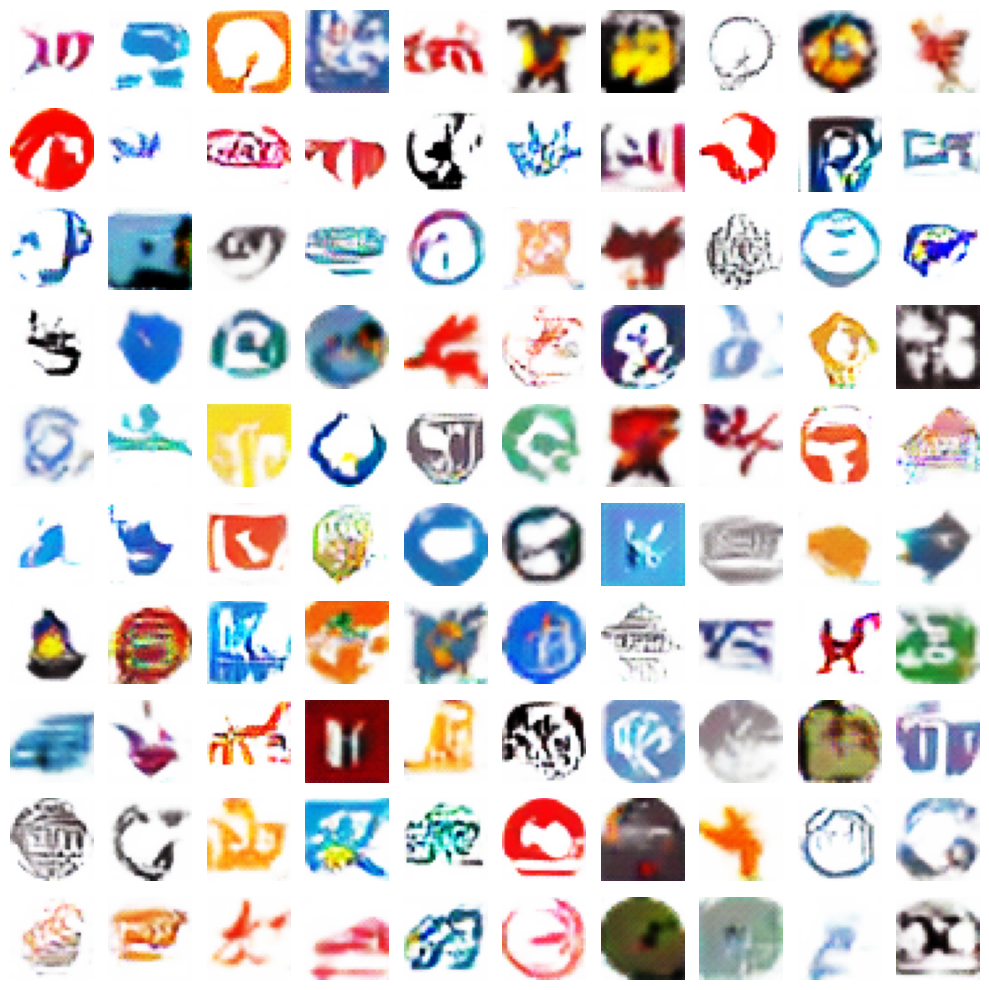

In [ ]:
# Chiamata della funzione per visualizzare la griglia di immagini generate
visualize_images()

#Calcolo del FID (Frechet Inception Distance)

Definiamo una funzione per calcolare il Frechet Inception Distance (FID) e confrontiamo immagini reali e generate.

Il Frechet Inception Distance (FID) è una metrica usata per valutare la qualità delle immagini generate da una GAN. Confronta la distribuzione delle feature estratte da un modello pre-addestrato (InceptionV3) tra le immagini reali e quelle generate.

In [ ]:
# Preparazione del modello InceptionV3
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Funzione per ridimensionare un array di immagini ad una nuova dimensione
def scale_images(images, new_shape):
    """
    Ridimensiona una collezione di immagini alla dimensione specifica (299x299x3).
    Args:
      	images: array o lista di immagini da ridimensionare.
      	new_shape: tupla che definisce la nuova dimensione.
    Return:
        Un array di immagini ridimensionate.
    """
    images_list = list()
    for image in images:
        # Ridimensiona l'immagine alla nuova dimensione.
        new_image = resize(image, new_shape, order=0)
        images_list.append(new_image)
    return asarray(images_list)

# Funzione per calcolare il Frechet Inception Distance (FID)
def calculate_fid(model, images1, images2):
    """
    Calcola il Frechet Inception Distance (FID) fra due insiemi di immagini.
    Args:
      	model: il modello InceptionV3 pre-addestrato utilizzato per estrarre le attivazioni.
     	  images1: primo set di immagini (immagini reali).
      	images2: secondo set di immagini (immagini generate).
    Return:
      	Il valore FID, una misura quantitativa della distanza tra le due distribuzioni.
    """
    # Estrae le attivazioni dal modello per ciascun set di immagini
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # Calcola la media e la matrice di covarianza delle attivazioni per ciascun set
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)

    # Calcola la somma dei quadrati delle differenze tra le medie
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Calcola la radice matriciale del prodotto tra le covarianze
    covmean = sqrtm(sigma1.dot(sigma2))

    # Se il risultato contiene componenti immaginarie (a causa di errori numerici) le converte in parte reale
    if iscomplexobj(covmean):
        covmean = covmean.real

    # Calcolo del FID
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


##Preparazione dell'insieme delle immagini reali

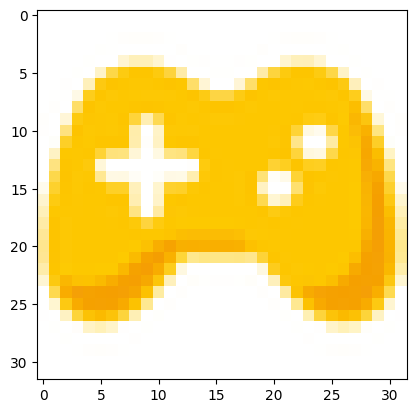

Valore minimo: 0.0
Valore massimo: 1.0


In [ ]:
# Numero di immagini da ottenere
num_images = 2000

# Lista delle immagini reali
images1 = []

# Itera sul dataset finché non raccoglie almeno num_images immagini
for batch in dataset:
    images1.extend(batch.numpy())
    if len(images1) >= num_images:
        break

# Converte la lista in un array numpy e prende solo le prime num_images immagini
images1 = np.array(images1[:num_images])

# Visualizza la prima immagine per verifica
plt.imshow(images1[0])
plt.show()

# Controlla il valore minimo e massimo nell'intero array delle immagini
print("Valore minimo:", images1.min())
print("Valore massimo:", images1.max())

##Preparazione dell'insieme delle immagini generate

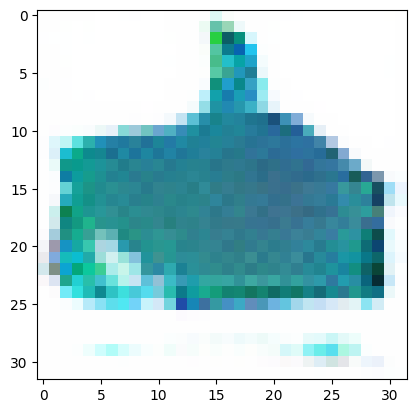

Valore minimo: 0
Valore massimo: 255


In [ ]:
# Genera vettori casuali per lo spazio latente
latent_vectors = tf.random.normal(shape=(num_images, latent_dim))

# Genera le immagini direttamente dal generatore
images2 = generator(latent_vectors, training=False)

# Converte le immagini al range [0,255]
images2 = images2 * 255.0
images2 = tf.cast(images2, tf.uint8).numpy()

# Visualizza un'immagine per verifica
plt.imshow(images2[0])
plt.show()

# Controlla il valore minimo e massimo nell'intero array delle immagini
print("Valore minimo:", images2.min())
print("Valore massimo:", images2.max())

##Calcolo della FID

In [ ]:
# Converte il tipo dei dati delle immagini in float32
images1 = images1.astype('float32')
images2 = images2.astype('float32')

# Per images1 normalizzate tra [0,1] le riporta a [0,255]
images1 = images1 * 255.0

# Ridimensiona le immagini al formato richiesto da InceptionV3
images1 = scale_images(images1, (299, 299, 3))
images2 = scale_images(images2, (299, 299, 3))
print('Immagini scalate:', images1.shape, images2.shape)

# Applica il preprocessamento specifico per InceptionV3, che trasforma immagini nel range [0,255] in immagini nel range [-1,1]
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# Calcolo FID
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

Immagini scalate: (2000, 299, 299, 3) (2000, 299, 299, 3)
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 342ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step
FID: 80.518
